## TEXT CLASSIFICATION
#### QUESTIONNAIRE CLASSIFICATION NOTEBOOK
#### USING MULTINOMIAL NAIVE BAYES ALGORITHM TO CLASSIFY THE TEXT


## IMPORTING LIBRARIES

In [1]:
import os
import re
import MeCab
import pickle
import gensim
import ast
import lda
import numpy as np
import pandas as pd
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
import gensim.corpora as corpora
from gensim import similarities 
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
import spacy
from pprint import pprint
import warnings
import logging
from google.cloud import storage as gcs
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, GridSearchCV, ShuffleSplit
from scipy.spatial.distance import pdist, squareform
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
from collections import Counter
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
%matplotlib inline

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/google/protobuf/descriptor.py:47: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from google.protobuf.pyext import _message


## IMPORTING DATASET
### THIS DATASET IS REFERED TO THE HAND-LABEL OVERALL SATISFACTION REASON FROM QUESTIONNAIRES

In [2]:
INPUT_BUCKET = 'gs://jesseulundo-bucket/questionnaire_classification/input_data/'
PROJECT_NAME = 'linkbal-dp'
BUCKET_NAME = 'mj-labeling-questionnaires-dev.datasets.linkbal.com' 
client = gcs.Client(PROJECT_NAME)
bucket = gcs.Bucket(client, name=BUCKET_NAME)
# JAPANESE STOPWORDS
jp_stop_words = pd.read_csv('gs://jesseulundo-bucket/questionnaire_classification/input_data/Japanese_stopword_list.txt', header=None, delimiter="\t")
# LABELLED QUESTIONNAIRE DATA HAND LABEL
qs = pd.read_csv(INPUT_BUCKET + 'ov_sat_cat_new.csv', sep=',')
qs

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning:

Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning:

Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/

//anaconda3/en

,id,overall_satisfaction,overall_satisfaction_reason,categories
0,111377,2,店舗スタッフの対応が悪い,スタッフの対応が悪い
1,111379,2,他のボドゲのお店だと店員や常連さんが気をきかせてくれていたので、そこと比べてしまうとどうして...,スタッフの対応が悪い
2,111381,2,想像していた人数よりも少ない。,参加人数が少ない
3,111383,2,大人数なのにマンツーマン、フリータイムが少ない。,出会えなかった
4,111386,2,食べ物が酒の肴にならない,飲食内容のが質が低い
...,...,...,...,...
1496,118219,2,年齢が上なため楽しめなかった,参加者の年齢が合っていない
1497,118228,2,運営の人の対応、食事どれも最悪です。20名くらいいるのにピザ1枚しか無かったり、利益率重視で...,飲食内容のが質が低い
1498,118230,1,スタッフのお兄さんはとても素敵でしたが、あとは全部ダメ,その他
1499,118239,1,この運営の仕方だとほんと1人参加限定じゃないと辛いです。友達と参加した意味ないです。最悪です。,スタッフの対応が悪い


### CATEGORIES LABELLING

In [3]:
category_codes = {'スタッフの対応が悪い': 0, '会場や雰囲気が悪い': 1, '参加者の年齢が合っていない': 2, '参加人数が少ない': 3, '出会えなかった': 4, '飲食内容のが質が低い': 5, 'その他': 6}

## DATA CLEANING AND PRE-PROCESSING

In [4]:
#qs = qs.drop(['want_recommend', 'want_recommend_reason'], axis=1)
qs = qs.dropna()
qs = qs.drop_duplicates() 
qs

,id,overall_satisfaction,overall_satisfaction_reason,categories
0,111377,2,店舗スタッフの対応が悪い,スタッフの対応が悪い
1,111379,2,他のボドゲのお店だと店員や常連さんが気をきかせてくれていたので、そこと比べてしまうとどうして...,スタッフの対応が悪い
2,111381,2,想像していた人数よりも少ない。,参加人数が少ない
3,111383,2,大人数なのにマンツーマン、フリータイムが少ない。,出会えなかった
4,111386,2,食べ物が酒の肴にならない,飲食内容のが質が低い
...,...,...,...,...
1496,118219,2,年齢が上なため楽しめなかった,参加者の年齢が合っていない
1497,118228,2,運営の人の対応、食事どれも最悪です。20名くらいいるのにピザ1枚しか無かったり、利益率重視で...,飲食内容のが質が低い
1498,118230,1,スタッフのお兄さんはとても素敵でしたが、あとは全部ダメ,その他
1499,118239,1,この運営の仕方だとほんと1人参加限定じゃないと辛いです。友達と参加した意味ないです。最悪です。,スタッフの対応が悪い


In [5]:
# REMOVING POSITIVE QUESTIONNAIRES AND MEANINGLESS COMMENTS
qs = qs[qs.overall_satisfaction < 3]
qs = qs[qs.overall_satisfaction_reason != '上記同様']
qs = qs[qs.overall_satisfaction_reason != '同上']
qs = qs[qs.overall_satisfaction_reason != '上記と同じ']
qs = qs[qs.overall_satisfaction_reason != '上記のとおり。']
qs = qs[qs.overall_satisfaction_reason != '上記記載']
qs

,id,overall_satisfaction,overall_satisfaction_reason,categories
0,111377,2,店舗スタッフの対応が悪い,スタッフの対応が悪い
1,111379,2,他のボドゲのお店だと店員や常連さんが気をきかせてくれていたので、そこと比べてしまうとどうして...,スタッフの対応が悪い
2,111381,2,想像していた人数よりも少ない。,参加人数が少ない
3,111383,2,大人数なのにマンツーマン、フリータイムが少ない。,出会えなかった
4,111386,2,食べ物が酒の肴にならない,飲食内容のが質が低い
...,...,...,...,...
1496,118219,2,年齢が上なため楽しめなかった,参加者の年齢が合っていない
1497,118228,2,運営の人の対応、食事どれも最悪です。20名くらいいるのにピザ1枚しか無かったり、利益率重視で...,飲食内容のが質が低い
1498,118230,1,スタッフのお兄さんはとても素敵でしたが、あとは全部ダメ,その他
1499,118239,1,この運営の仕方だとほんと1人参加限定じゃないと辛いです。友達と参加した意味ないです。最悪です。,スタッフの対応が悪い


### DATA DISTRIBUTION BY EACH CATEGORY

In [6]:
print(qs['categories'].value_counts())
qs_age = qs[qs.categories == '参加者の年齢が合っていない']
qs_staff = qs[qs.categories == 'スタッフの対応が悪い']
qs_num_att = qs[qs.categories == '参加人数が少ない']
qs_meet = qs[qs.categories == '出会えなかった']
qs_location = qs[qs.categories == '会場や雰囲気が悪い']
qs_food_drink = qs[qs.categories == '飲食内容のが質が低い']
qs_other = qs[qs.categories == 'その他']
print("CATEGORY DISTRIBUTION: ")
print("NUMBER OF QUESTIONNAIRES ABOUT AGE COMPLAINS: ", len(qs_age))
print("NUMBER OF QUESTIONNAIRES ABOUT STAFF COMPLAINS: ", len(qs_staff))
print("NUMBER OF QUESTIONNAIRES ABOUT NUMBER OF PARTICIPANTS COMPLAINS: ", len(qs_num_att))
print("NUMBER OF QUESTIONNAIRES ABOUT NO MATCH COMPLAINS: ", len(qs_meet))
print("NUMBER OF QUESTIONNAIRES ABOUT EVENT SPACE COMPLAIN: ", len(qs_location))
print("NUMBER OF QUESTIONNAIRES ABOUT FOOD AND DRINK COMPLAIN: ", len(qs_food_drink))
print("NUMBER OF QUESTIONNAIRES ABOUT OTHER COMPLAINS: ", len(qs_other))

その他              447
参加人数が少ない         337
スタッフの対応が悪い       231
会場や雰囲気が悪い        170
飲食内容のが質が低い       145
出会えなかった          128
参加者の年齢が合っていない     31
Name: categories, dtype: int64
CATEGORY DISTRIBUTION: 
NUMBER OF QUESTIONNAIRES ABOUT AGE COMPLAINS:  31
NUMBER OF QUESTIONNAIRES ABOUT STAFF COMPLAINS:  231
NUMBER OF QUESTIONNAIRES ABOUT NUMBER OF PARTICIPANTS COMPLAINS:  337
NUMBER OF QUESTIONNAIRES ABOUT NO MATCH COMPLAINS:  128
NUMBER OF QUESTIONNAIRES ABOUT EVENT SPACE COMPLAIN:  170
NUMBER OF QUESTIONNAIRES ABOUT FOOD AND DRINK COMPLAIN:  145
NUMBER OF QUESTIONNAIRES ABOUT OTHER COMPLAINS:  447


### TOKENIZING AND STEMMING

In [7]:
tagger = MeCab.Tagger()
def tokenize_stemmer(text):
    lemmas = []
    for line in tagger.parse(text).splitlines()[:-1]:
        surface, feature = line.split('\t')
        if feature.split(',')[6] != '*':
            lemmas.append(feature.split(',')[6])
    return lemmas

In [8]:
qs['tokenized_overall_satisfaction_reason'] = qs.apply(lambda row: tokenize_stemmer(row['overall_satisfaction_reason']), axis=1)
qs

,id,overall_satisfaction,overall_satisfaction_reason,categories,tokenized_overall_satisfaction_reason
0,111377,2,店舗スタッフの対応が悪い,スタッフの対応が悪い,"[店舗, スタッフ, の, 対応, が, 悪い]"
1,111379,2,他のボドゲのお店だと店員や常連さんが気をきかせてくれていたので、そこと比べてしまうとどうして...,スタッフの対応が悪い,"[他, の, の, お, 店, だ, と, 店員, や, 常連, さん, が, 気, を, ..."
2,111381,2,想像していた人数よりも少ない。,参加人数が少ない,"[想像, する, て, いる, た, 人数, より, も, 少ない, 。]"
3,111383,2,大人数なのにマンツーマン、フリータイムが少ない。,出会えなかった,"[大, 人数, だ, のに, マンツーマン, 、, フリー, タイム, が, 少ない, 。]"
4,111386,2,食べ物が酒の肴にならない,飲食内容のが質が低い,"[食べ物, が, 酒, の, 肴, に, なる, ない]"
...,...,...,...,...,...
1496,118219,2,年齢が上なため楽しめなかった,参加者の年齢が合っていない,"[年齢, が, 上, だ, ため, 楽しめる, ない, た]"
1497,118228,2,運営の人の対応、食事どれも最悪です。20名くらいいるのにピザ1枚しか無かったり、利益率重視で...,飲食内容のが質が低い,"[運営, の, 人, の, 対応, 、, 食事, どれ, も, 最悪, です, 。, 名, ..."
1498,118230,1,スタッフのお兄さんはとても素敵でしたが、あとは全部ダメ,その他,"[スタッフ, の, お, 兄さん, は, とても, 素敵, です, た, が, 、, あと,..."
1499,118239,1,この運営の仕方だとほんと1人参加限定じゃないと辛いです。友達と参加した意味ないです。最悪です。,スタッフの対応が悪い,"[この, 運営, の, 仕方, だ, と, ほんと, 人, 参加, 限定, じゃ, ない, ..."


### REMOVING STOPWORDS

In [9]:
stop = jp_stop_words.values.tolist()
stop = [item for sublist in stop for item in sublist]
qs['tokenized_overall_satisfaction_reason'] = qs['tokenized_overall_satisfaction_reason'].apply(lambda x: [item for item in x if item not in stop])
qs

,id,overall_satisfaction,overall_satisfaction_reason,categories,tokenized_overall_satisfaction_reason
0,111377,2,店舗スタッフの対応が悪い,スタッフの対応が悪い,"[店舗, スタッフ, 対応, 悪い]"
1,111379,2,他のボドゲのお店だと店員や常連さんが気をきかせてくれていたので、そこと比べてしまうとどうして...,スタッフの対応が悪い,"[店員, 常連, きかせる, 比べる, どうしても, 多い]"
2,111381,2,想像していた人数よりも少ない。,参加人数が少ない,"[想像, 人数, 少ない]"
3,111383,2,大人数なのにマンツーマン、フリータイムが少ない。,出会えなかった,"[大, 人数, マンツーマン, フリー, タイム, 少ない]"
4,111386,2,食べ物が酒の肴にならない,飲食内容のが質が低い,"[食べ物, 酒, 肴]"
...,...,...,...,...,...
1496,118219,2,年齢が上なため楽しめなかった,参加者の年齢が合っていない,"[年齢, 楽しめる]"
1497,118228,2,運営の人の対応、食事どれも最悪です。20名くらいいるのにピザ1枚しか無かったり、利益率重視で...,飲食内容のが質が低い,"[運営, 対応, 食事, 最悪, ピザ, 無い, たり, 利益, 率, 重視, 逆, おかげ..."
1498,118230,1,スタッフのお兄さんはとても素敵でしたが、あとは全部ダメ,その他,"[スタッフ, 兄さん, 素敵, ダメ]"
1499,118239,1,この運営の仕方だとほんと1人参加限定じゃないと辛いです。友達と参加した意味ないです。最悪です。,スタッフの対応が悪い,"[運営, 仕方, ほんと, 参加, 限定, 辛い, 友達, 参加, 意味, 最悪]"


### LABEL LOADING

In [10]:
qs['category_code'] = qs['categories']
qs = qs.replace({'category_code':category_codes})
qs

,id,overall_satisfaction,overall_satisfaction_reason,categories,tokenized_overall_satisfaction_reason,category_code
0,111377,2,店舗スタッフの対応が悪い,スタッフの対応が悪い,"[店舗, スタッフ, 対応, 悪い]",0
1,111379,2,他のボドゲのお店だと店員や常連さんが気をきかせてくれていたので、そこと比べてしまうとどうして...,スタッフの対応が悪い,"[店員, 常連, きかせる, 比べる, どうしても, 多い]",0
2,111381,2,想像していた人数よりも少ない。,参加人数が少ない,"[想像, 人数, 少ない]",3
3,111383,2,大人数なのにマンツーマン、フリータイムが少ない。,出会えなかった,"[大, 人数, マンツーマン, フリー, タイム, 少ない]",4
4,111386,2,食べ物が酒の肴にならない,飲食内容のが質が低い,"[食べ物, 酒, 肴]",5
...,...,...,...,...,...,...
1496,118219,2,年齢が上なため楽しめなかった,参加者の年齢が合っていない,"[年齢, 楽しめる]",2
1497,118228,2,運営の人の対応、食事どれも最悪です。20名くらいいるのにピザ1枚しか無かったり、利益率重視で...,飲食内容のが質が低い,"[運営, 対応, 食事, 最悪, ピザ, 無い, たり, 利益, 率, 重視, 逆, おかげ...",5
1498,118230,1,スタッフのお兄さんはとても素敵でしたが、あとは全部ダメ,その他,"[スタッフ, 兄さん, 素敵, ダメ]",6
1499,118239,1,この運営の仕方だとほんと1人参加限定じゃないと辛いです。友達と参加した意味ないです。最悪です。,スタッフの対応が悪い,"[運営, 仕方, ほんと, 参加, 限定, 辛い, 友達, 参加, 意味, 最悪]",0


In [11]:
qs_new = qs[pd.notnull(qs['tokenized_overall_satisfaction_reason'])]
qs_new['tokenized_overall_satisfaction_reason'] = [' '.join(map(str, l)) for l in qs['tokenized_overall_satisfaction_reason']]
qs_new
print(qs_new['tokenized_overall_satisfaction_reason'])

0                                          店舗 スタッフ 対応 悪い
1                                店員 常連 きかせる 比べる どうしても 多い
2                                              想像 人数 少ない
3                                大 人数 マンツーマン フリー タイム 少ない
4                                                食べ物 酒 肴
                              ...                       
1496                                             年齢 楽しめる
1497    運営 対応 食事 最悪 ピザ 無い たり 利益 率 重視 逆 おかげ 参加 同士 愚痴る 合える
1498                                      スタッフ 兄さん 素敵 ダメ
1499                      運営 仕方 ほんと 参加 限定 辛い 友達 参加 意味 最悪
1500                          目的 出会い 全く 繋がる 運営 孤軍 奮闘 気の毒
Name: tokenized_overall_satisfaction_reason, Length: 1489, dtype: object


## TRAIN AND TEST SPLIT

In [12]:
X_train, X_test, y_train, y_test = train_test_split(qs_new['tokenized_overall_satisfaction_reason'], 
                                                    qs['category_code'], 
                                                    test_size=0.15, 
                                                    random_state=8)

### PARAMETERS SELECTION

In [13]:
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

In [14]:
X_train = X_train.values.tolist()
X_train

['',
 '酒 オーダー リモコン 番号 テーブル 番号 一致 ドリンク 注文 混乱 多い',
 '司会 下手 長い 面白い',
 '学歴 低い',
 'やはり 人数 問題 あり また スタッフ 丁寧 少し 暗い',
 '会場 ちゃんと 出会い',
 '全員 話せる',
 '男性 悪い',
 '男女 比 集客 共に 最低 少 人数 開催 参加 全員 帰る',
 'スタッフ そもそも 記入 カード',
 '女性 集客 致命',
 'ほとんど 説明 不安 わかる 状態 開始 終了 しっかり',
 'そもそも 値段 設定 おかしい',
 '詐欺',
 '最初 参加 人数 提示 少ない 分かる 行く',
 '全員 話せる 決まり 決める 替える',
 '値段 割 食事',
 '参加 人数 少ない',
 'ご飯 美味しい',
 '誇大 広告 絶対 人数 少ない ちゃんと 書く 下さる',
 '圧倒的 人数 少ない 女子 人数 対応 不安',
 '少ない という フリー タイム あっさり 終わる 満足',
 '最低',
 '進行 女性 態度 悪い すぎる',
 '全然 違う',
 '二度と 行く',
 '少ない 中止',
 '街 コン 未来 会社 まじ 考える 当日 人数 少ない 開催 ちゃんと 考える',
 '動く 方式 正直 テーブル 話す わかる 順番 回す 唯一 残念',
 'トーク タイム 短い すぎる',
 'イベント 趣旨 逸脱 心理 カード ゲーム スタッフ 進行 無い どういう 店員 主催 側 聞く 貰う 連絡 つく 言う 最後 まで 待つ 返答 説明 メール お待ち 返金 お待ち',
 'また 利用',
 'プロフィール カード 残念 項目 少ない 出身 情報 料理 考える 少ない すぎる 一瞬 種類 少ない 美味しい 料理 出会い メイン 街 コン 料理 つける 高い 満足 食う せる スタッフ 声 小さい 聞こえる 半 個室 大変 けど それなら スタッフ 増やす',
 '男女 比率 おかしい',
 '女性 帰る せる',
 'ドリンク 絶対 頼む いける 書く 覚え ぐらい ドリンク チケット スタッフ 断る 「 取る 食事 なんか ルール 言う 疑問 浮かぶ 一応 趣味 コン 違う 婚 活 恋 活 相手 でも という なぜ 男女 金額 差 出る 来

## TEXT REPRESENTATION

In [15]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)                        
features_train = tfidf.fit_transform(X_train)
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(1265, 264)
(224, 264)


In [16]:
for category, category_id in sorted(category_codes.items()):
    features_chi2 = chi2(features_train, labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' CATEGORY:".format(category))
    print(" MOST CORRELATED UNIGRAMS:\n. {}".format('\n. '.join(unigrams[-5:])))
    print(" MOST CORRELATED BIGRAMS:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")

# 'その他' CATEGORY:
 MOST CORRELATED UNIGRAMS:
. スタッフ
. 通り
. 人数
. 理由
. 少ない
 MOST CORRELATED BIGRAMS:
. 参加 人数
. 人数 少ない

# 'スタッフの対応が悪い' CATEGORY:
 MOST CORRELATED UNIGRAMS:
. 受付
. 進行
. 運営
. 司会
. スタッフ
 MOST CORRELATED BIGRAMS:
. 悪い すぎる
. スタッフ 対応

# '会場や雰囲気が悪い' CATEGORY:
 MOST CORRELATED UNIGRAMS:
. づらい
. 場所
. スペース
. 会場
. 狭い
 MOST CORRELATED BIGRAMS:
. 参加 人数
. 人数 少ない

# '出会えなかった' CATEGORY:
 MOST CORRELATED UNIGRAMS:
. 話す
. 交換
. 替え
. マッチング
. 出会い
 MOST CORRELATED BIGRAMS:
. 全員 話せる
. 連絡 交換

# '参加人数が少ない' CATEGORY:
 MOST CORRELATED UNIGRAMS:
. 女性
. 中止
. 男女
. 少ない
. 人数
 MOST CORRELATED BIGRAMS:
. 参加 人数
. 人数 少ない

# '参加者の年齢が合っていない' CATEGORY:
 MOST CORRELATED UNIGRAMS:
. 限定
. 多い
. 以外
. お願い
. 年齢
 MOST CORRELATED BIGRAMS:
. 男性 参加
. 女性 参加

# '飲食内容のが質が低い' CATEGORY:
 MOST CORRELATED UNIGRAMS:
. ドリンク
. 食事
. ご飯
. 食べ物
. 料理
 MOST CORRELATED BIGRAMS:
. 少ない 過ぎる
. 料理 少ない



## SAVING THE FILES

In [17]:
# X_train
with open('/Users/jesse.ulundo/demo_tests/mnb/X_train_MNB.pickle', 'wb') as output:
    pickle.dump(X_train, output)
    
# X_test    
with open('/Users/jesse.ulundo/demo_tests/mnb/X_test_MNB.pickle', 'wb') as output:
    pickle.dump(X_test, output)
    
# y_train
with open('/Users/jesse.ulundo/demo_tests/mnb/y_train_MNB.pickle', 'wb') as output:
    pickle.dump(y_train, output)
    
# y_test
with open('/Users/jesse.ulundo/demo_tests/mnb/y_test_MNB.pickle', 'wb') as output:
    pickle.dump(y_test, output)
    
# df
with open('/Users/jesse.ulundo/demo_tests/mnb/df_qs_MNB.pickle', 'wb') as output:
    pickle.dump(qs, output)
    
# features_train
with open('/Users/jesse.ulundo/demo_tests/mnb/features_train_MNB.pickle', 'wb') as output:
    pickle.dump(features_train, output)

# labels_train
with open('/Users/jesse.ulundo/demo_tests/mnb/labels_train_MNB.pickle', 'wb') as output:
    pickle.dump(labels_train, output)

# features_test
with open('/Users/jesse.ulundo/demo_tests/mnb/features_test_MNB.pickle', 'wb') as output:
    pickle.dump(features_test, output)

# labels_test
with open('/Users/jesse.ulundo/demo_tests/mnb/labels_test_MNB.pickle', 'wb') as output:
    pickle.dump(labels_test, output)
    
# TF-IDF object
with open('/Users/jesse.ulundo/demo_tests/mnb/tfidf_MNB.pickle', 'wb') as output:
    pickle.dump(tfidf, output)

In [18]:
#!gsutil -m cp *.pickle gs://jesseulundo-bucket/questionnaire_classification/train_and_test_data/

## MODEL TRAINING

In [19]:
# Dataframe
path_df_qs = "/Users/jesse.ulundo/demo_tests/mnb/df_qs_MNB.pickle"
with open(path_df_qs, 'rb') as data:
    df_qs_MNB = pickle.load(data)

# features_train
path_features_train = "/Users/jesse.ulundo/demo_tests/mnb/features_train_MNB.pickle"
with open(path_features_train, 'rb') as data:
    features_train_MNB = pickle.load(data)

# labels_train
path_labels_train = "/Users/jesse.ulundo/demo_tests/mnb/labels_train_MNB.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train_MNB = pickle.load(data)

# features_test
path_features_test = "/Users/jesse.ulundo/demo_tests/mnb/features_test_MNB.pickle"
with open(path_features_test, 'rb') as data:
    features_test_MNB = pickle.load(data)

# labels_test
path_labels_test = "/Users/jesse.ulundo/demo_tests/mnb/labels_test_MNB.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test_MNB = pickle.load(data)

In [20]:
print(features_train_MNB.shape)
print(features_test_MNB.shape)

(1265, 264)
(224, 264)


### CROSSVALIDATING FOR HYPERPARAMETER TUNING USING MULTINOMIAL NAIVE BAYES

In [21]:
mnbc = MultinomialNB()
mnbc

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Model fit and performance

In [22]:
mnbc.fit(features_train_MNB, labels_train_MNB)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [23]:
mnbc_pred = mnbc.predict(features_test_MNB)

## RESULTS 
#### Training accuracy

In [24]:
# Training accuracy
print("THE TRAINING ACCURACY IS: ")
print(accuracy_score(labels_train_MNB, mnbc.predict(features_train_MNB)))

THE TRAINING ACCURACY IS: 
0.6845849802371542


#### Test accuracy

In [25]:
# Test accuracy
print("THE TEST ACCURACY IS: ")
print(accuracy_score(labels_test_MNB, mnbc_pred))

THE TEST ACCURACY IS: 
0.5535714285714286


#### Classification report

In [26]:
# Classification report
print("CLASSIFICATION REPORT")
print(classification_report(labels_test_MNB, mnbc_pred))

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.69      0.67      0.68        36
           1       0.38      0.11      0.17        27
           2       0.00      0.00      0.00         9
           3       0.66      0.82      0.73        50
           4       0.60      0.14      0.22        22
           5       0.69      0.41      0.51        22
           6       0.44      0.76      0.55        58

    accuracy                           0.55       224
   macro avg       0.49      0.41      0.41       224
weighted avg       0.54      0.55      0.51       224



//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



#### CONFUSION MATRIX

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 12473 missing from current font.

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 12479 missing from current font.

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 12483 missing from current font.

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 12501 missing from current font.

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 12398 missing from current font.

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 23550 missing from current font.

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/matplotlib/b

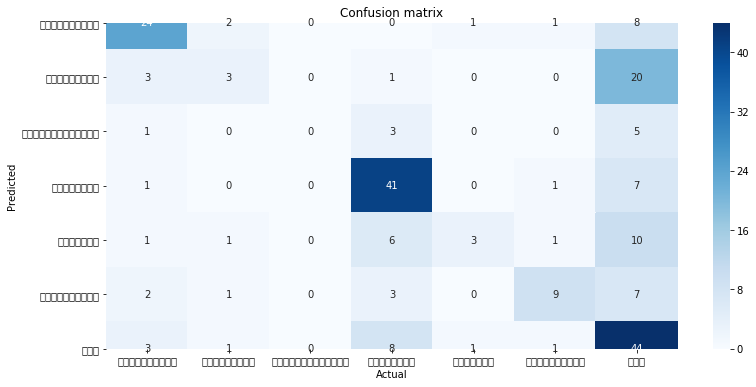

In [27]:
aux_df = df_qs_MNB[['categories', 'category_code']].drop_duplicates().sort_values('category_code')
conf_matrix = confusion_matrix(labels_test_MNB, mnbc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['categories'].values, 
            yticklabels=aux_df['categories'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [28]:
d = {
     'Model': 'Multinomial Naïve Bayes',
     'Training Set Accuracy': accuracy_score(labels_train_MNB, mnbc.predict(features_train_MNB)),
     'Test Set Accuracy': accuracy_score(labels_test_MNB, mnbc_pred)
}

df_models_mnbc = pd.DataFrame(d, index=[0])
df_models_mnbc

,Model,Training Set Accuracy,Test Set Accuracy
0,Multinomial Naïve Bayes,0.684585,0.553571


In [29]:
#with open('Models/best_mnbc.pickle', 'wb') as output:
#    pickle.dump(mnbc, output)
    
#with open('Models/df_models_mnbc.pickle', 'wb') as output:
#    pickle.dump(df_models_mnbc, output)